In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
import sys
import random
import cv2
%matplotlib inline

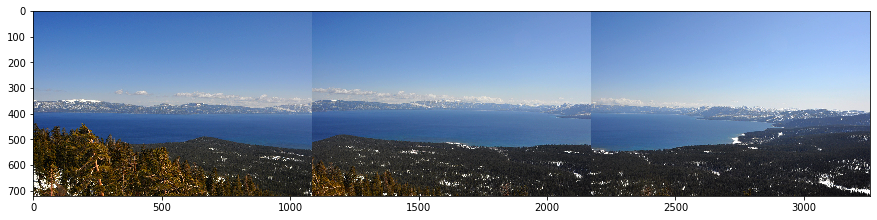

In [2]:
plt.rcParams['figure.figsize'] = [15, 15]

def load_image(filename):
    img = np.asarray(Image.open(filename))
    img = img.astype("float32")/255.
    return img

def show_image(img):
    plt.imshow(img, interpolation='nearest')
    
center_img = load_image("mountain_center.png")
left_img   = load_image("mountain_left.png")
right_img  = load_image("mountain_right.png")

show_image(np.concatenate([left_img, center_img, right_img], axis=1))

In [3]:
def compute_homography(src, dst):
    '''Computes the homography from src to dst.
    
    Input:
        src: source points, shape (n, 2)
        dst: destination points, shape (n, 2)
    Output:
        H: homography from source points to destination points, shape (3, 3)
        
    TODO: Implement the A matrix. 
    '''
    
    A = np.zeros([2*src.shape[0], 9])
    # Your code here.
    # temp array1: size: 2n * 3, every rows is [xi,yi,1]: points in src
    temp_array1 = np.ones([2*src.shape[0], 3])
    temp_array1[0:2*src.shape[0]:2, 0:2] = src[:,:]
    temp_array1[1:2*src.shape[0]:2, 0:2] = src[:,:]
    
    #print("temp_array1  ", temp_array1)
        
    # temp array2: size 2n*1, like [[-x0'],[-y0'],[-x1'],[-y'],......], these from dst 
    temp_array2 = np.zeros([2*dst.shape[0], 1])
    
    temp_array2[0:2*dst.shape[0]:2,:] = dst[:,0]
    temp_array2[1:2*dst.shape[0]:2,:] = dst[:,1]
    
    #print("temp_array2   ", temp_array2)
    
    # Combine
    A[0:A.shape[0]:2,0:2] = src
    A[1:A.shape[0]:2,3:5] = src
    
    A[0:A.shape[0]:2,2] = 1
    A[1:A.shape[0]:2,5] = 1
    
    A[:,6:9] = - temp_array2 * temp_array1
    
    
    w, v = np.linalg.eig(np.dot(A.T, A))
    index = np.argmin(w)
    H = v[:, index].reshape([3,3])
    return H
    

def apply_homography(src, H):
    '''Applies a homography H onto the source points.
    
    Input:
        src: source points, shape (n, 2)
        H: homography from source points to destination points, shape (3, 3)
    Output:
        dst: destination points, shape (n, 2)
    
    TODO: Implement the apply_homography function
    '''
    #implement this using homogenous coordinates.
    src_h = np.ones([src.shape[0], 3])
    src_h[:,0:2] = src
    
    # return value dst
    dst = np.zeros([src.shape[0],2])
    dst_h_t = np.dot(H, np.transpose(src_h))
    dst_h = np.transpose(dst_h_t)
    dst[:,0] = dst_h[:,0] / dst_h[:,2]
    dst[:,1] = dst_h[:,1] / dst_h[:,2]
    
    return dst

In [4]:
def test_blend(mode):
    fish_img = load_image("escher_fish.png")[:, :, :3]
    horse_img = load_image("escher_horsemen.png")[:, :, :3]

    blend_img = blend_image_pair(fish_img, binary_mask(fish_img), horse_img, binary_mask(horse_img), mode)

    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(fish_img, cmap='gray')
    axarr[1].imshow(horse_img, cmap='gray')
    axarr[2].imshow(blend_img,cmap='gray')
    
#test_blend("blend")
test_blend("overlay")


NameError: name 'blend_image_pair' is not defined

In [ ]:
from scipy.ndimage.morphology import distance_transform_edt as euc_dist

def blend_image_pair(src_img, src_mask, dst_img, dst_mask, mode):
    '''Given two images and their binary masks, blend the two images.
    
    Input:
        src_img: First image to be blended, shape (m, n, 3)
        src_mask: src_img's binary mask, shape (m, n)
        dst_img: Second image to be blended, shape (m, n, 3)
        dst_mask: dst_img's binary mask, shape (m, n)
        mode: Blending mode, either "overlay" or "blend"
    Output:
        Blended image of shape (m, n, 3)
    
    TODO: Implement the blend_image_pair function.
    '''
    # overlay
    
    if mode == "overlay":
        m_temp = src_mask - dst_mask
        m_src_new = m_temp > 0
        m_src_new = m_src_new.astype("int")
        
        src_final = np.zeros([src_img.shape[0],src_img.shape[1],3])
        
        src_final[:,:,0] = m_src_new * src_final[:,:,0]
        src_final[:,:,1] = m_src_new * src_final[:,:,1]
        src_final[:,:,2] = m_src_new * src_final[:,:,2]
        
        overlay_image = src_final + dst_img
        
        return overlay_image
     
    # alpha blending
    
    if mode == "blend":
        m_temp2 = src_mask + dst_mask
        m_temp2 = m_temp2 > 0
        m_temp2.astype("int")
        sum_over_rows = np.sum(m_temp2, axis=1)
        alpha = m_temp2

        i = 0
        for i in range(m_temp2.shape[1]):
            alpha[:,i] = alpha[:,i] / sum_over_rows
            if i > 1:
                alpha[:,i] = alpha[:,i-1] + alpha[:,i]
        
        # alpha: increasing with the increase of the column number range(0 - 1)
        f_alpha = src_img
        f_alpha[:,:,0] = src_img[:,:,0] * (1 - alpha)
        f_alpha[:,:,1] = src_img[:,:,1] * (1 - alpha)
        f_alpha[:,:,2] = src_img[:,:,2] * (1 - alpha)

        h_alpha = dst_img
        h_alpha[:,:,0] = dst_img[:,:,0] * alpha
        h_alpha[:,:,1] = dst_img[:,:,1] * alpha
        h_alpha[:,:,2] = dst_img[:,:,2] * alpha
        blend_image = f_alpha + h_alpha
        return blend_image
      

In [16]:
import cv2.Image
im = Image.open("p_left.jpg")
im.save("p_left.png", "PNG")

ModuleNotFoundError: No module named 'cv2.Image'

In [ ]:
a = np.ones([3,3])

In [ ]:
b = np.zeros([3,3])

In [ ]:
b

In [ ]:
b[:,:] = a[:,:]

In [ ]:
b[0][0] = 10

In [ ]:
b

In [ ]:
a

In [ ]:
range(1)

In [ ]:
for i in range(1):
    print(i)

In [ ]:
dst_img = np.zeros([dst_img_size[0], dst_img_size[1],3])
    while num_row < dst_img_size[0]:
        while num_column < dst_img_size[1]:
            temp_d = np.array([[num_row],[num_column],[1]])
            temp_s = np.dot(H,temp_d)
            temp_s = (temp_s / temp_s[2][0])
            x = int(temp_s[0][0])
            y = int(temp_s[1][0])
            if x >= 0 and x < src_img.shape[0]:
                if y >= 0 and y < src_img.shape[1]:
                    dst_img[num_row][num_column] = src_img[x][y]
            num_column = num_column + 1
        num_row = num_row + 1
            
    return dst_img

In [ ]:
'''
ts = np.ones([src_pts.shape[0],3])
ts[:,0:2] = src_pts
np.dot(H_t_inv,(np.dot(H_t, np.transpose(ts))))
'''


In [ ]:
H_t_inv =  np.linalg.inv(H)
#H_t_inv
t1 = np.ones([canvas_pts.shape[0],3])
t1[:,0:2] = canvas_pts
temp = np.dot(H_t_inv, np.transpose(t1))
temp
#temp[0][0] / temp[2][0]


In [5]:
 a = np.ones([5,5,3])

In [7]:
b = np.zeros([5,5,3])

In [11]:
a[4,4] = b[4,4]

In [13]:
a

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [0., 0., 0.]]])